In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#filename="droneData2.csv"


##### Load data from a group of simulations run purely randomly. No priority was given for proximity to warehouses or orders.

In [56]:
df = pd.read_csv(r'droneRandomData.csv')

##### Columns from this randomized data are:
**score:**  The calculated score for this particular manifest. High=Fast/Best  Low=slow/worst<br>
**seq:**   which sequential manifest of the simulation this occured in<br>
**row,col:**   The starting position of the drone to load<br>
**order1-9:**   Which order number (0-~9400) was loaded<br>

Each row represents a drone that is fully loaded (by weight)

In [57]:
df

,score,seq,row,col,order1,order2,order3,order4,order5,order6,order7,order8,order9
0,57,0,113,179,8836,4214.0,5328.0,4399.0,1795.0,NaN,NaN,NaN,NaN
1,114,1,113,179,8588,5363.0,8230.0,405.0,NaN,NaN,NaN,NaN,NaN
2,156,2,113,179,1827,407.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN
3,78,3,113,179,862,239.0,2027.0,NaN,NaN,NaN,NaN,NaN,NaN
4,92,4,113,179,415,8354.0,6818.0,5277.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
534849,182,2546,228,169,7487,3094.0,4837.0,6939.0,NaN,NaN,NaN,NaN,NaN
534850,85,2547,25,99,8854,5607.0,1217.0,NaN,NaN,NaN,NaN,NaN,NaN
534851,91,2548,149,297,7498,6247.0,6090.0,NaN,NaN,NaN,NaN,NaN,NaN
534852,91,2549,257,192,446,7804.0,9122.0,3527.0,NaN,NaN,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

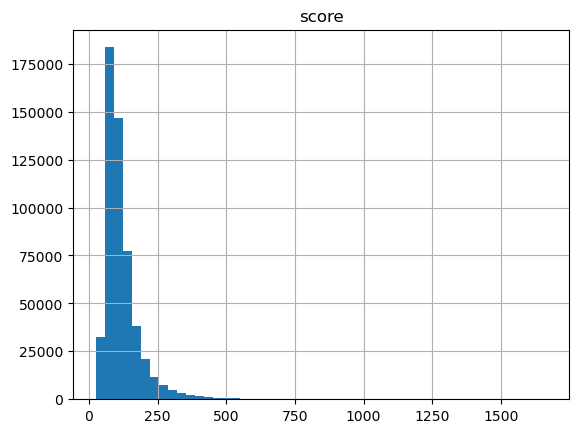

In [58]:
df.hist(column='score', bins=50)

In [59]:
np.std( df['score']) 

70.35438199921313

In [60]:
np.mean( df['score']) 

117.95250853503947

In [ ]:
This graph attempts to answer the question: If an available drone at a random location chooses randomly from orders to load, what would score would that set of loading and delivery flights result in? 

While the overall StdDev and mean may be of interest later; since the game scoring is based on scoring the soonest (scores are weighted based on when they occur in the time span of a game) the mean for the first few rounds are much more significant than the last rounds.
So this data should be viewed by sequence number NOT over all sequences combined.
With this dataset being purely random gameplay, the result should be flat. Later, an effective algorithm will bias high scores to early rounds.


Text(0, 0.5, 'Mean score')

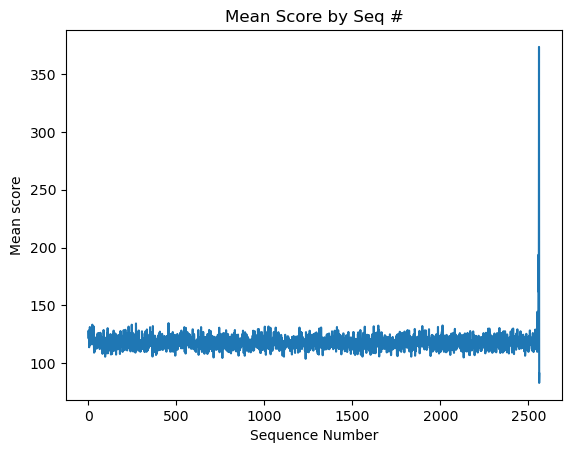

In [61]:
#show mean score by sequence number
ax=df.groupby('seq')['score'].mean().plot(title='Mean Score by Seq #')
ax.set_xlabel("Sequence Number")
ax.set_ylabel("Mean score")

As expected, the mean score is not obviously biased on sequence number. This is a decent indication that the algorithm to generate the dataset has minimal bias. Of Note: the wide deviation at the highest sequence numbers would likely be due to the last flights having less than a full manifest as the orders have been exhausted. A single item on the last flight close to a warehouse would result in a high score. Conversely a single last item far from the warehouse would result in a lower than typical score.
Scoring formula used is the inverse of the total duration of the flight to fulfill a single manifest. The flight starts at the drones first position (cols 3&4 in the dataset), traverses to each warehouse and order location and finishes at the closest warehouse to the last customer delivery.


Current load time for a simulation is about 7 seconds. Full simulation run (1 episode=70 seconds)

Cogitating this overnight and reviewing documentation at: https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html I found the return calculation for this type of problem is called Infinite-horizon, discounted return.
I came to the realization that facilitating the AI model's learning of the probability of a given product being available in a given warehouse (randomized for each episode in my current code) would only be able to be (learned) over many (10,000+?) episodes of simulations. While this is technically possible with a few 10's of Gigabytes of storage, storing these neural connections in a model seems much more practical to say nothing of space-efficiency.
Therefore, I will re-code to create an agent that can be queried rapidly. It will include a reset function to begin an episode and score each query (drone manifest load process). It will present an episode-sequence#, row,col simulation state with action input for (order(1-9000),warehouse(1-30)),(order,warehouse),(order,warehouse)....
and respond with a score. The end of the episode will also result in an actual final score.

The number of (order,warehouse) positions to provide for the AI to guess needs to be scoped in relation to the problem. If 100 options were provided, it would likely be a significant time before the discovery that anything more than about 5 would result in failure to fly. To that end, I will initially limit the option to about 7.


A further epiphany is that my formulation of the code abstraction of the model is contrived and precludes the option of the AI selecting to transfer items between warehouses or to simply wait in a given location. This simplification of the problem set obviates the possible emergence of non-intuitive solutions. This possibility of weak-emergence is extremely interesting to me so I will attempt a reformulation of a queryable agent to include these possibilities.


Result of coding the agent using list comprehensions everywhere practical has a load time of .001 seconds. 


Based on the randomized actions in the graph above, if an algo can **exceed a score of 140** during early sequences, it is a strong indication of an effective model.


While setting up the model parameters for the observations for the model, I realized that returning the row,col as the position was unnecessary. I changed that to be an index value representing the row and column.


The first attempt of generating an AI was utilizing the PPO model within Stable Baselines 3 which is a collection of algorithms for PyTorch. The action used was drone number, and the requisite parameters to load or unload that drone. 
The result of running the initial training setup was an error (tried training multiple times but errored after a few minutes):



> <pre>File ~\AppData\Roaming\Python\Python39\site-packages\stable_baselines3\common\preprocessing.py:114, in <listcomp>(.0)
    108     return F.one_hot(obs.long(), num_classes=observation_space.n).float()
    110 elif isinstance(observation_space, spaces.MultiDiscrete):
    111     # Tensor concatenation of one hot encodings of each Categorical sub-space
    112     return th.cat(
    113         [
--> 114             F.one_hot(obs_.long(), num_classes=int(observation_space.nvec[idx])).float()
    115             for idx, obs_ in enumerate(th.split(obs.long(), 1, dim=1))
    116         ],
    117         dim=-1,
    118     ).view(obs.shape[0], sum(observation_space.nvec))
    120 elif isinstance(observation_space, spaces.MultiBinary):
    121     return obs.float()

**<em>RuntimeError: Class values must be smaller than num_classes.</em>**

</pre>

This appeared to be resolved by increasing my observation values by one (1). 
>self.observation_space =gym.spaces.MultiDiscrete(np.array([2001,9369,31,1254,11]))

This appears to have resolved the problem where one-hot encoding output won't fit in the observation space provided. In this case, it appears to be a off-by-one error on my part.

As I continually tried changes the action and observation spaces, I frequently experienced similar errors when my code caused values to exceed the previously defined shapes. Running the double-check routine I found used in an example helped to discover these errors early before initiating an hours-long training session.


Proximal Policy Optimization Algorithms (PPO) paper ==>  https://arxiv.org/pdf/1707.06347.pdf

In [2]:
#!pip install stable-baselines3[extra] --user

### Tensorboard of initial training sessions:

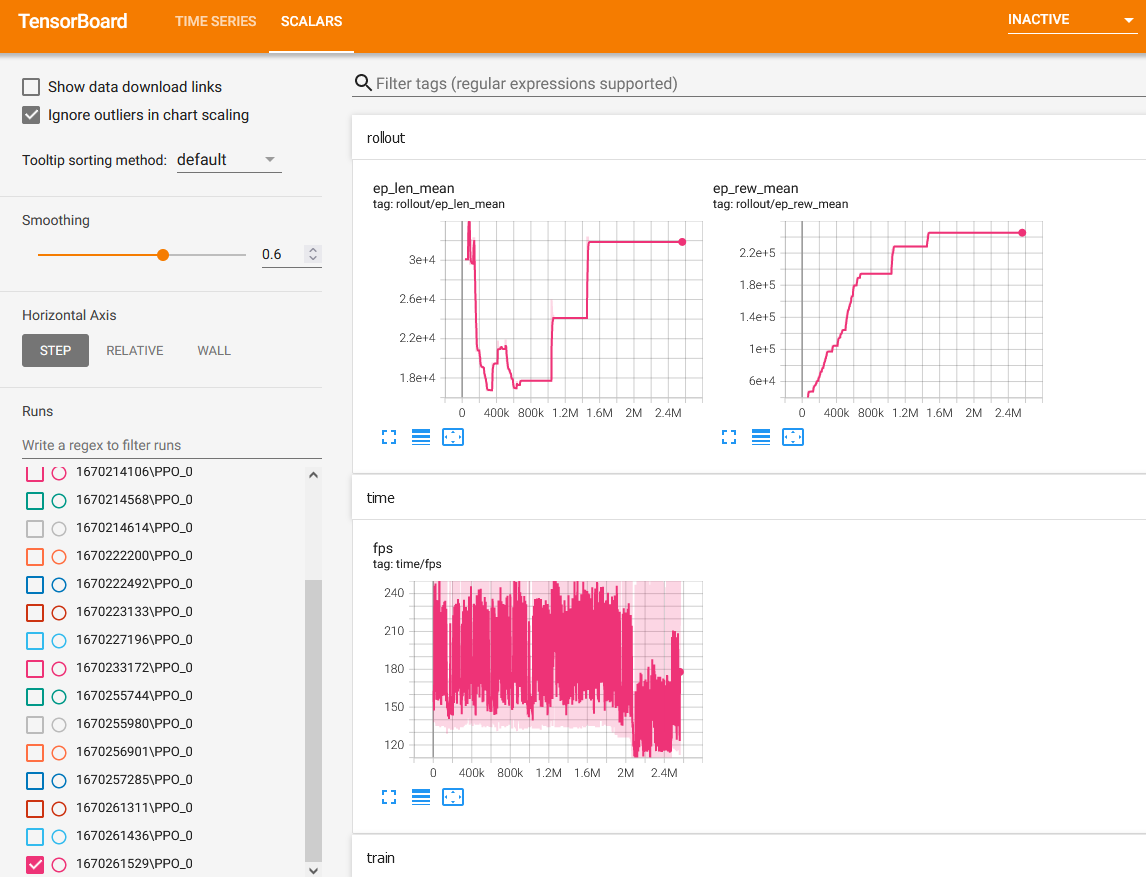

Of note: The fps graph sharp change just after 2M is at the time of starting a Zoom call on the same PC running the training session. The uptick beyond 2.4M is coterminal with the end of the call.
    

What are the objectives that the hyperparameters should be tuned for? <br>
* Fulfilling an order closest to the beginning should score highest
* Drones should (mostly) load up to capacity at a warehouse before starting deliveries


What properties might be emergent?<br>
* Drones fill the most efficient orders and not others
* Some drone flights/manifests may include transferring goods between warehouses to facilitate a later delivery
* Drone may not be empty when stopping at a warehouse to refill
* Cooperation between drones



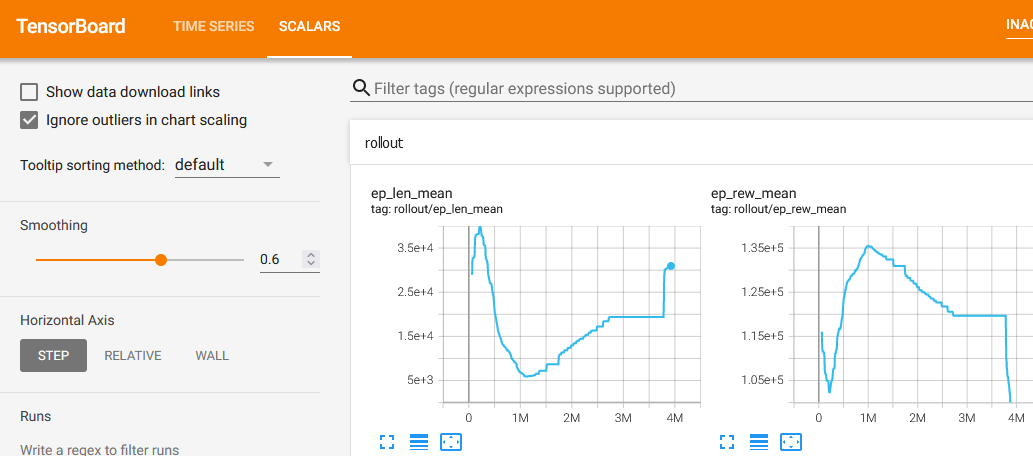

As can be seen in the above Tensorboard plot (minimized dataset:54 orders/3 drones), the mean reward starts to decline after the 1M episode mark until at the 2.75M episode mark it flatlines since all orders have been completed in those scenarios as the model terminates episodes when all orders have been fulfilled.


Key references: https://stable-baselines3.readthedocs.io/en/v0.11.1/guide/rl.html

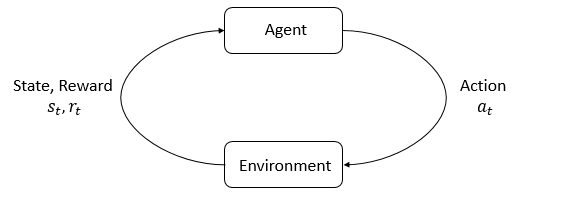
Source: https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#what-can-rl-do

Definitions:
* *s*<sub>*t*</sub>  The state of the complete system at time t. 
* *a*<sub>*t*</sub>  The action taken at time t.
* Policy: The rule used by an agent to determine its next action.
* Trajectory=rollout=episode: The sequence of states and actions taken over time. Denoted: $\tau$ = (*s*<sub>*0*</sub>,*a*<sub>*0*</sub>+*s*<sub>*1*</sub>,*a*<sub>*1*</sub>,...)
    
    There are two types of policies used in reinforcement learning (RL), probabilistic and deterministic. Probabilistic being, obviously, a field of probabilities, and deterministic, a set of **discrete** possibilities.
    

As an example, from a humanistic perspective, for a person within the confines of a room, the state ( *S*<sub>*t*</sub>) would be every particle, or field, inside the room at a given moment.
Our observations (senses) are tuned to a small amount of the total information thereby facilitating processing within the processing capabilities of our brains. 
This combination of a limited observation space within an (essentially) infinite domain, results in turning a truly stochastic system (probabilities) into a perceived deterministic (discrete possibilities) 



An example of making a more complex policy ruleset can reflect in a significantly more complex reward curve (more inflection points) using this model. 
In this circumstance, the reward penalty for unloading or loading was changed from zero (red) to a negative log value based on the distance to the warehouse (pink) but only for the first item to be loaded/unloaded- zero otherwise. 
(Depicts 131 orders/10 drones)


Reward shaping:

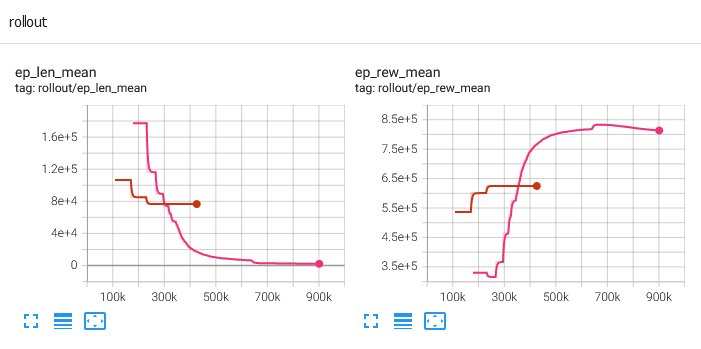

#### Revisions of the rewards and punishment continues....
With negative-valued punishments for invalid commands, for instance, attempt to load a product not in the warehouse or deliver a product not currently onboard the drone; and positively valued rewards for (successfully) loading and delivering, the AI evolved to using a single drone almost exclusively and generally loading a single product followed by delivering that product. 
Since the scoring calculation is currently based on the total possible time, the difference between delivering early or a bit later is miniscule. This does not appear to nudge it in the right direction sufficiently. 
Need to alter to make time a biger factor. Next effort will be to use the current manifest number as the timer.

#### The frames per second my PC can process for this pyTorch configuration is about twice as fast for the CPU vs GPU. <br>
CPU(pink): Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz GPU(orange):NVIDIA GeForce RTX 2080Ti 

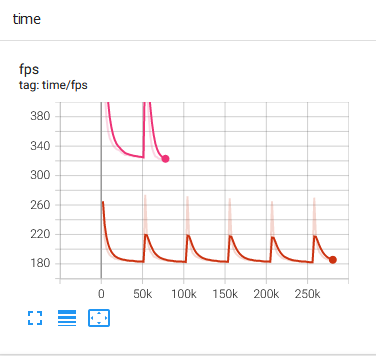

Therefore, forcing the learning process to onlyuse the cpu is necessary since pyTorch will default to the GPU if it finds it. 
> model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=logdir, **device='cpu'** )

Making little mistakes like trying to coax intermodal transfer (warehouse to warehouse) by giving a slight reward for delivering a product to a warehouse that is low on inventory of an item, but neglecting to exclude the possibility of the stock having originated from that same warehouse, resulted in the AI devolving to just loading and subsequently unloading the same product to the same warehouse. Crafting these rulesets is very particular as the AI is fairly efficient at finding weak spots in the logic.
 

The Kaggle challenge submission has a specific format required: e.g. 
> Example command: 0 L 1 2 3 (Command to drone 0, load at warehouse 1 products of product type
2, three of them.
> Example command: 0 D 1 2 3 (Command to drone 0, deliver for order 1 items of product type 2,
three of them
       
Of note is the third field which indicates the warehouse number in the 'Load' context, but order number in the 'Deliver' context. Trying to have the AI 'discover' this led to very poor results.  Ultimately, I changed the action so the fields consistently had the same context (drone number, action type, location, order number) which helped training progress more smoothly. This required an extra final conversion during the formulation of the submission file. 